# CME 241 : ASSIGNMENT 4 - DYNAMIC PROGRAMMING
#####  Emile Clastres

 We start value iteration with $ V_0 = 
\begin{bmatrix}10\\1\\0\end{bmatrix}$

After one iteration we get:
$ V_1 = B^*(V_0) =
\begin{bmatrix}11.2\\4.3\\0\end{bmatrix}$
with associated q-values $q_1 (s_1, \cdot) = \begin{bmatrix}10.6\\11.2\end{bmatrix}$ and $q_1 (s_2, \cdot) = \begin{bmatrix}4.3\\4.3\end{bmatrix}$

After a second iteration we get 
$ V_2 = B^*(V_1) =
\begin{bmatrix}12.82\\6.75\\0\end{bmatrix}$
with associated q-values $q_2 (s_1, \cdot) = \begin{bmatrix}12.82\\11.98\end{bmatrix}$ and $q_2 (s_2, \cdot) = \begin{bmatrix}5.65\\6.75\end{bmatrix}$


At this point, it is pointless to iterate more to produce the optimal deterministic policy, as it will stay as $\pi_D = \begin{bmatrix}a_1\\a_2\end{bmatrix}$.

Indeed, the coefficients of the linear combination between the values of V that are used ot compute the q-values are all positive, and there is stricly more weights for action $a_1$ in $s_1$ and $a_2$ in $s_2$. Therefore $V_n$ is an increasing sequence and increasing $V$ will never change $\pi_D$ after iteration 2.

More formally, we can observe that if $V_j \leq V_i$, then $q_j(s_2, a_2)-qj(s_2, a_1) \leq q_i(s_2, a_2)-q_i(s_2, a_1)$ and $q_j(s_1, a_1)-qj(s_2, a_2) \leq q_i(s_1, a_1)-q_i(s_2, a_2)$, which yields the conclusion straightforwardly.


Therefore, $\pi^*_D = \pi_2 = \begin{bmatrix}a_1\\a_2\end{bmatrix}$

## 2) Return of the croaking 🐸
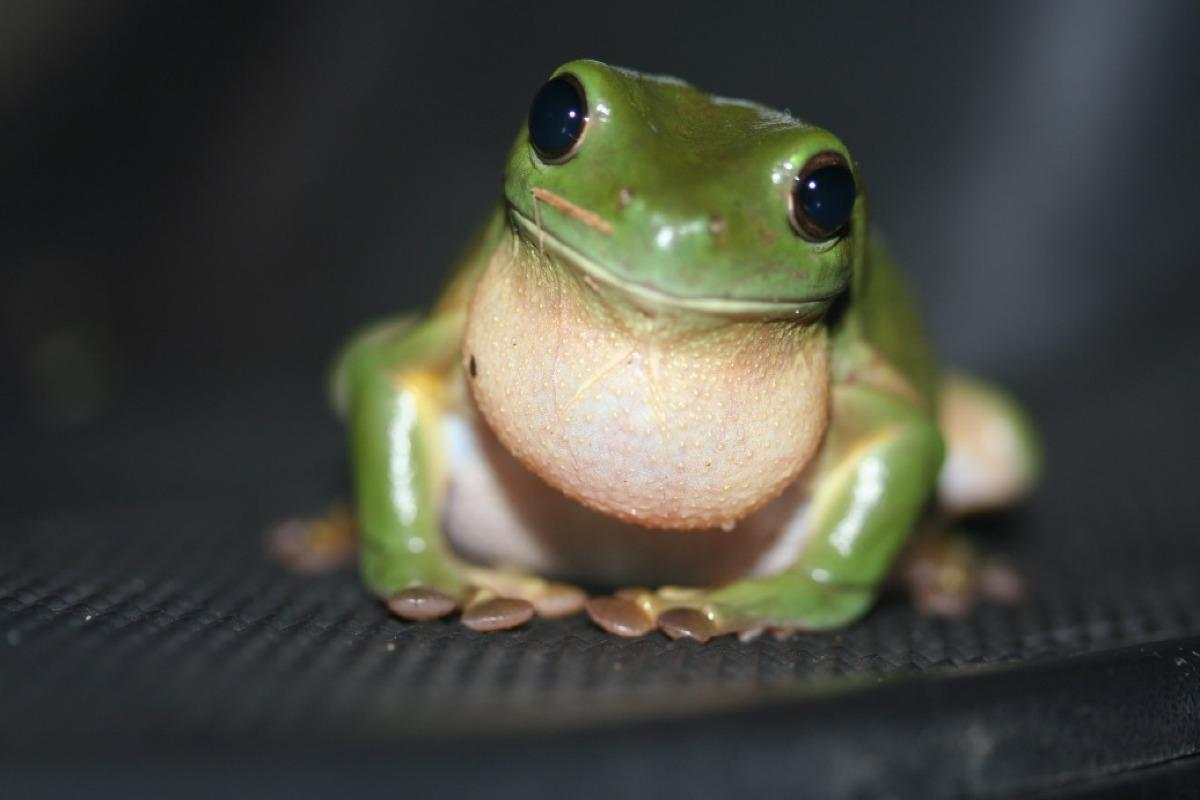

In [1]:
from rl.markov_decision_process import FiniteMarkovDecisionProcess, FinitePolicy, StateActionMapping, S, A
from rl.distribution import Categorical, Constant
class Frog(FiniteMarkovDecisionProcess):
    def __init__(self, n):
        def reward(i):
            return float(i==n)-float(i==0) 
        mapping : StateActionMapping[S,A] = {}
        mapping[0] = None
        mapping[n] = None
        for i in range(1,n):
            mapping[i]={}
            mapping[i]['A'] = Categorical({(i-1, reward(i-1)):i/n, (i+1, reward(i+1)):(n-i)/n })
            mapping[i]['B'] = Categorical({(j, reward(j)):1/n for j in range(0,n+1) if j!=i})
        super().__init__(mapping)


To compare the different algorithms, we will take a look at runtime as well as number of iterations. To this end, we add the function converged_counted to rl/iterate.py, which does the same as converged but additionally prints the number of iterations before convergence. Its code is presented below for the record. We modify value_iteration_result and value_iteration_result accordingly to print the number of iterations if the bool print_steps is True.

Warning : the cell below won't run, it is just a copy of the addendums to rl/iterate.py

def converged_counted(values: Iterator[X],
                    done: Callable[[X, X], bool]) -> X:
    '''Return the final value of the given iterator and prints the number of iterations when its values
    converge according to the done function.

    Raises an error if the iterator is empty.

    Will loop forever if the input iterator doesn't end *or* converge.
    '''
    result = None
    count:int = 0
    for val in converge(values, done):
        count+=1
        result = val

    if result is None:
        raise ValueError("converged called on an empty iterator")
    else:
        print(f"Converged in {n} iterations.")
    return result


def policy_iteration_result(
    mdp: FiniteMarkovDecisionProcess[S, A],
    gamma: float,
    print_steps: bool = False
) -> Tuple[V[S], FinitePolicy[S, A]]:
	if not print_steps:
    	return converged(policy_iteration(mdp, gamma), done=almost_equal_vf_pis)
    else:
    	return converged_counted(policy_iteration(mdp, gamma), done=almost_equal_vf_pis)


def value_iteration_result(
    mdp: FiniteMarkovDecisionProcess[S, A],
    gamma: float,
    print_steps: bool = False
) -> Tuple[V[S], FinitePolicy[S, A]]:
	if not print_steps:
	    opt_vf: V[S] = converged(
	        value_iteration(mdp, gamma),
	        done=almost_equal_vfs
	    )
	else:
		opt_vf: V[S] = converged_counted(
	        value_iteration(mdp, gamma),
	        done=almost_equal_vfs
	    )
    opt_policy: FinitePolicy[S, A] = greedy_policy_from_vf(
        mdp,
        opt_vf,
        gamma
    )

    return opt_vf, opt_policy

In [12]:
from rl.dynamic_programming import value_iteration_result, policy_iteration_result

def enumerate_all_deterministic_policies(k):
    def enumerate_all_combinations(n):
        assert n >=0
        if n == 0:
            return [{0:None}]
        elif n==1:
            return [{0: None, 1:None}]
        else:
            res =[]
            policies_previous = enumerate_all_combinations(n-1)
            for policy in policies_previous:
                policy[n] = None
                p1, p2 = policy.copy(), policy.copy()
                p1[n-1] = Constant('A')
                p2[n-1] = Constant('B')
                res.append(p1)
                res.append(p2)
            return res
    policies = enumerate_all_combinations(k)
    return [FinitePolicy(policy) for policy in policies]


import numpy as np
def brute_force_optimal_V(n, gamma = 1.):
    policies = enumerate_all_deterministic_policies(n)

    for i,policy in enumerate(policies):
        V = Frog(n).apply_finite_policy(policy).get_value_function_vec(gamma)
        if i == 0:
            V_star = V
            Pi_star = policy
        elif np.all(V >= V_star):
            V_star = V
            Pi_star = policy
    return V_star, Pi_star

### Comparison for n=5

Policy iteration

In [3]:
frog_mdp = Frog(5)

In [11]:
%%time
res = policy_iteration_result(mdp = frog_mdp, gamma = 1, print_steps = True)

Converged in 4 iterations.
CPU times: user 12.8 ms, sys: 2.75 ms, total: 15.6 ms
Wall time: 13.8 ms


In [10]:
%%time
res = value_iteration_result(mdp = frog_mdp, gamma = 1, print_steps = True)

Converged in 90 iterations.
CPU times: user 2.79 ms, sys: 79 µs, total: 2.87 ms
Wall time: 2.81 ms


In [13]:
%%time
res = brute_force_optimal_V(5, 1)

CPU times: user 10.3 ms, sys: 2.08 ms, total: 12.4 ms
Wall time: 11.4 ms


### Comparison for n=20

In [16]:
frog_mdp = Frog(20)

In [17]:
%%time
res = policy_iteration_result(mdp = frog_mdp, gamma = 1, print_steps = True)

Converged in 7 iterations.
CPU times: user 353 ms, sys: 6.26 ms, total: 359 ms
Wall time: 356 ms


In [18]:
%%time
res = value_iteration_result(mdp = frog_mdp, gamma = 1, print_steps = True)

Converged in 99 iterations.
CPU times: user 28.8 ms, sys: 2.58 ms, total: 31.4 ms
Wall time: 29.9 ms


In [23]:
%%time
res = brute_force_optimal_V(15, 1)

CPU times: user 24.5 s, sys: 2.18 s, total: 26.7 s
Wall time: 14.5 s


### Results : Value iteration is clearly the fastest, most scalable algorithm. Brute force doesn't scale to more than n=1(. Remember that iteration-wise, we are only counting the outer-loop iterations for policy iteration (hence the lower number)

## Large n=200 instance:

In [24]:
frog_mdp = Frog(200)


In [25]:
%%time
res = policy_iteration_result(mdp = frog_mdp, gamma = 1, print_steps = True)

Converged in 4 iterations.
CPU times: user 9.74 s, sys: 898 ms, total: 10.6 s
Wall time: 5.84 s


In [26]:
%%time
res = value_iteration_result(mdp = frog_mdp, gamma = 1, print_steps = True)

Converged in 97 iterations.
CPU times: user 1.6 s, sys: 14.2 ms, total: 1.61 s
Wall time: 1.63 s


Interestingly, the number of iterations required seems independant of $n$.

In [28]:
from time import time
import matplotlib.pyplot as plt

In [49]:
brute_t = []
value_t = []
policy_t = []
Ns = [2,3,4,5,6,7,8,9, 14, 20, 30, 50, 75, 100]
Ns_brute = [n for n in Ns if n <= 15]
for n in Ns:
    frog_mdp = Frog(n)
    if n <= 15:
        t=time()
        res = brute_force_optimal_V(n, 1)
        brute_t.append(time()-t)
    t = time()
    res = value_iteration_result(mdp = frog_mdp, gamma = 1, print_steps = False)
    value_t.append(time()-t)
    t= time()
    res = policy_iteration_result(mdp = frog_mdp, gamma = 1, print_steps = False)
    policy_t.append(time()-t)


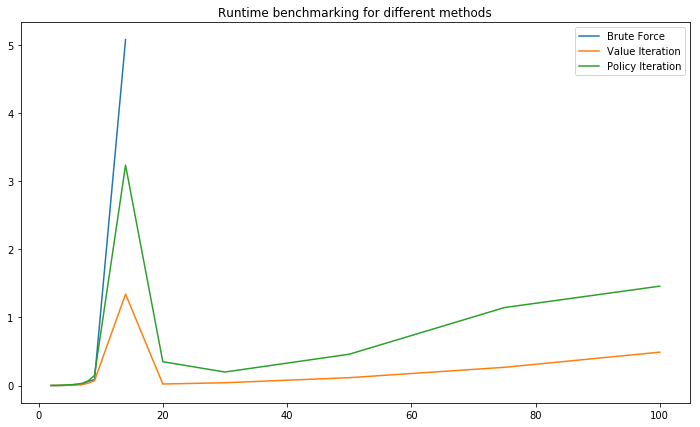

In [50]:
plt.figure(figsize = (12, 7))
plt.plot(Ns_brute, brute_t, label = 'Brute Force')
plt.plot(Ns, value_t, label = 'Value Iteration')
plt.plot(Ns, policy_t, label = 'Policy Iteration')
plt.title('Runtime benchmarking for different methods')
plt.legend()
plt.show()

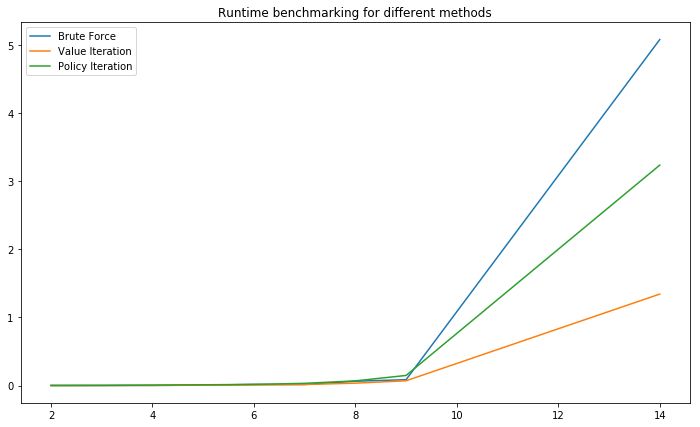

In [51]:
b = len(Ns_brute)
plt.figure(figsize = (12, 7))
plt.plot(Ns_brute, brute_t, label = 'Brute Force')
plt.plot(Ns[:b], value_t[:b], label = 'Value Iteration')
plt.plot(Ns[:b], policy_t[:b], label = 'Policy Iteration')
plt.title('Runtime benchmarking for different methods')
plt.legend()
plt.show()

## 3) Job-Hopping and Wages-Utility-Maximization

The states are $ \mathcal{S} = \{u, j_1, ..., j_n\}$ where $u$ stands for unemployed and $j_i$ for "employed at job i". The actions are $\mathcal{A} = \{a,d,k\}$ for accept offer, decline offer and keep job, respectively.

We will define the reward to be $R_{t+1} = log(w_t)$ where t is the job where the worker is emplyed at time t.
More formally:

$$\mathcal{P}(u, a, j_i) = p_i ,~~~~~~\mathcal{P}(u, d, u) = 1$$
$$\mathcal{P}(j_i, k, j_i) = 1-\alpha ,~~~~~~\mathcal{P}(j_i, k, u) = \alpha$$
$$\mathcal{R}(u, a) = E_{p}{log(w)},~~~~~~ \mathcal{R}(u, d) = log(w_0) $$
$$\mathcal{R}(j_i, k) = log(w_i) $$

In this case, it is easier to formalize directly the state-reward transition function:
$$\mathcal{P}_R(u,log(w_0), a, j_i) = p_i ,~~~~~~\mathcal{P}_R(u,log(w_0), d, u) = 1$$
$$\mathcal{P}_R(j_i, log(w_i), k, j_i) = 1-\alpha ,~~~~~~\mathcal{P}_R(j_i, 0, k, u) = \alpha$$


##### Actually, the above formulation doens't give the agent the opportunity to know what offer he has before accepting or declining employment. 
This is not an interesting problem. In this stuation, the optimal policy will just be to accept any job offer (provided that $w_0 \leq w_i ~ \forall i$). However, if we augment the state with $R_t$ then the agent will be able to see his wage one timestep later and determine whether or not he should stay (we should allow him to willfully quit his job).


###### To go back to the original problem, we need the agent to know his offer before accepting or refusing it. Therefore we need to replace the state u with n states $u_1, ..., u_n$ corresponding to "unemployed with offer i".

The transitions become:
$$\mathcal{P}_R(u_i,log(w_i), a, j_i) = 1 ,~~~~~~\mathcal{P}_R(u_i,log(w_0), d, u_j) = p_j$$
$$\mathcal{P}_R(j_i, log(w_i), k, j_i) = 1-\alpha ,~~~~~~\mathcal{P}_R(j_i, 0, k, u_j) = \frac{\alpha}{n} $$

and


$$\mathcal{P}(u_k, a, j_k) = 1 ,~~~~~~\mathcal{P}(u_k, d, u_i) = \frac{1}{n}$$
$$\mathcal{P}(j_i, k, j_i) = 1-\alpha ,~~~~~~\mathcal{P}(j_i, k, u_j) = \frac{\alpha}{n}$$
$$\mathcal{R}(u_i, a) = log(w_i),~~~~~~ \mathcal{R}(u_i, d) = log(w_0) $$
$$\mathcal{R}(j_i, k) = log(w_i) $$


Let's try to find the optimal policy with just intuitive logic.

If we are employed, then we have no choice but to keep it : $\pi_D(j_i) = k$
If we are unemployed and given an offer that we don't know, we can expect to get utility $\sum_{i \geq 1}{log(w_i)}$
Therefore, we will decline any offer $i$ if and only if  $log(w_i) \geq log(w_0) + \gamma \sum_{i \geq 1}{log(w_i)}$, the second term being the expected discounted two-steps reward for declining the job offer.

therefore $$\pi_D(u_i) = a ~~ \text{if} ~~log(w_i) > log(w_0) + \gamma \sum_{i \geq 1}{log(w_i)}, ~~\text{else}~~ d$$

The Bellman optimality equation writes:

$$$$